# Session 3 - Non-parametric Regression

## Content

- [Lab: 7.8.1 Polynomial Regression and Step Functions](#7.8.1-Polynomial-Regression-and-Step-Functions)
- [Lab: 7.8.2 Splines](#7.8.2-Splines)

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

%matplotlib inline
plt.style.use('seaborn-white')

## Load dataset
Using write.csv in R, I exported the dataset from package 'ISLR' to a csv file.

In [5]:
df = pd.read_csv('data/Wage.csv')
df.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3000 non-null   int64  
 1   year        3000 non-null   int64  
 2   age         3000 non-null   int64  
 3   sex         3000 non-null   object 
 4   maritl      3000 non-null   object 
 5   race        3000 non-null   object 
 6   education   3000 non-null   object 
 7   region      3000 non-null   object 
 8   jobclass    3000 non-null   object 
 9   health      3000 non-null   object 
 10  health_ins  3000 non-null   object 
 11  logwage     3000 non-null   float64
 12  wage        3000 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 304.8+ KB


## Lab

### 7.8.1 Polynomial Regression and Step Functions

Create polynomials for 'age'. These correspond to those in R, when using raw=TRUE in poly() function.

In [7]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

y = (df.wage > 250).map({False:0, True:1}).values
print('X4:\n', X4[:5])
print('y:\n', y[:5])

X4:
 [[1.000000e+00 1.800000e+01 3.240000e+02 5.832000e+03 1.049760e+05]
 [1.000000e+00 2.400000e+01 5.760000e+02 1.382400e+04 3.317760e+05]
 [1.000000e+00 4.500000e+01 2.025000e+03 9.112500e+04 4.100625e+06]
 [1.000000e+00 4.300000e+01 1.849000e+03 7.950700e+04 3.418801e+06]
 [1.000000e+00 5.000000e+01 2.500000e+03 1.250000e+05 6.250000e+06]]
y:
 [0 0 0 0 0]


#### Linear regression model. (Degree 4)

In [8]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


Selecting a suitable degree for the polynomial of age.

In [9]:
fit_1 =  sm.GLS(df.wage, X1).fit()
fit_2 =  sm.GLS(df.wage, X2).fit()
fit_3 =  sm.GLS(df.wage, X3).fit()
fit_4 =  sm.GLS(df.wage, X4).fit()
fit_5 =  sm.GLS(df.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The polynomial degree 4 seems best.

In [10]:
X = X4

Scikit-learn implements a regularized logistic regression model particularly suitable for high dimensional data. Since we just have one feature (age) we use the GLM model from statsmodels.

In [26]:
clf = sm.GLM(y, X, family=sm.families.Binomial())
res = clf.fit()

Create array of test data. Transform to polynomial degree 4 and run prediction.

In [27]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

In [28]:
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = res.predict(X_test)

### Figure 7.1

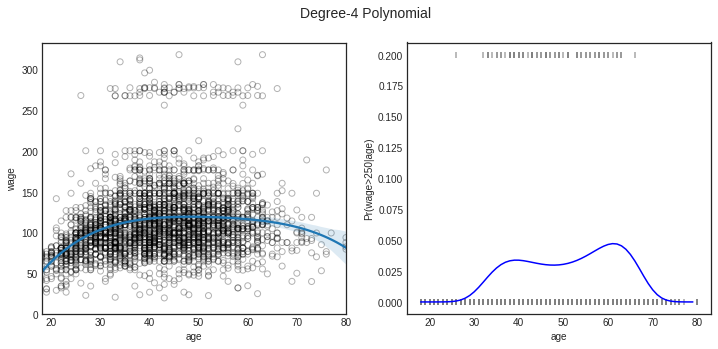

In [30]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(x=df.age, y=df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

#### Step function

In [31]:
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [32]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

,age,age_cuts,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293
4,50,"(49.0, 64.5]",75.043154


In [33]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head(5)

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,0,1,0,0
3,1.0,0,1,0,0
4,1.0,0,0,1,0


In [34]:
# Using statsmodels because it has a more complete output for coefficients
fit3 = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [35]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [36]:
# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.head()

,const,2,3,4
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


#### Linear Regression

In [37]:
pred2 = fit3.predict(X_test2)

#### Logistic Regression

In [22]:
clf2 = sm.GLM(y, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1),
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

/home/mcourt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


### Figure 7.2

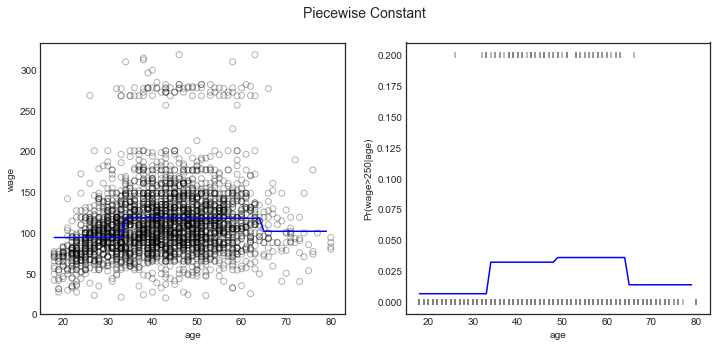

In [28]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

### 7.8.2 Splines

Using patsy to create non-linear transformations of the input data. See http://patsy.readthedocs.org/en/latest/ <BR>
I have not found functions to create smoothing splines or GAMs or do local regression.

#### Cubic splines

In [42]:
# Specifying 3 knots
transformed_x = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit4 = sm.GLM(df.wage, transformed_x).fit()
pred4 = fit4.predict(dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit4.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

In [43]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit5 = sm.GLM(df.wage, transformed_x2).fit()
pred5 = fit5.predict(dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit5.params

Intercept                                                 56.313841
bs(df.age, df=6, degree=3, include_intercept=False)[0]    27.824002
bs(df.age, df=6, degree=3, include_intercept=False)[1]    54.062546
bs(df.age, df=6, degree=3, include_intercept=False)[2]    65.828391
bs(df.age, df=6, degree=3, include_intercept=False)[3]    55.812734
bs(df.age, df=6, degree=3, include_intercept=False)[4]    72.131473
bs(df.age, df=6, degree=3, include_intercept=False)[5]    14.750876
dtype: float64

#### Natural splines

In [44]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit6 = sm.GLM(df.wage, transformed_x3).fit()
pred6 = fit6.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
fit6.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

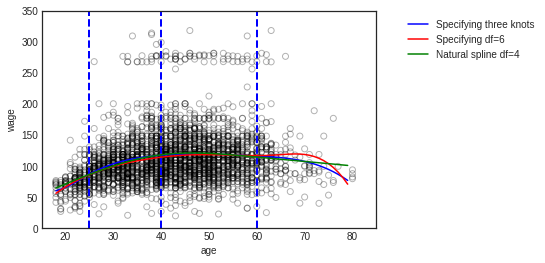

In [45]:
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred4, color='b', label='Specifying three knots')
plt.plot(age_grid, pred5, color='r', label='Specifying df=6')
plt.plot(age_grid, pred6, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');

## Local Regression